# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [38]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [39]:
%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


In [40]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

    
model.materials = openmc.Materials([uo2, zirconium, water]) 
model.materials.export_to_xml()

### Create pincell

In [51]:
def pincell(index_x,index_y):
    fuel_outer_radius = openmc.ZCylinder(r=0.39)
    clad_inner_radius = openmc.ZCylinder(r=0.40)
    clad_outer_radius = openmc.ZCylinder(r=0.46)
    pitch = 1.26
    
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    
    fuel_region = -fuel_outer_radius
    gap_region = +fuel_outer_radius & -clad_inner_radius
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
    fuel = openmc.Cell(name='fuel'+'_'+str(index_x)+'_'+str(index_y))
    fuel.fill = uo2
    fuel.region = fuel_region
    gap = openmc.Cell(name='gap'+'_'+str(index_x)+'_'+str(index_y))
    gap.region = gap_region
    clad = openmc.Cell(name='clad'+'_'+str(index_x)+'_'+str(index_y))
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+str(index_x)+'_'+str(index_y))
    moderator.fill = water
    moderator.region = water_region
    
    u = openmc.Universe(name='u'+'_'+str(index_x)+'_'+str(index_y),cells=(fuel, gap, clad, moderator))
    return(u,fuel,gap,clad,moderator)

### Create guide tube

In [66]:
def guide(index_x,index_y):
    
    clad_inner_radius = openmc.ZCylinder(r=0.5610)
    clad_outer_radius = openmc.ZCylinder(r=0.6020)
    pitch = 1.26
    
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    
    
    
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    water_guide_region= -clad_inner_radius

    water_guide = openmc.Cell(name='water_guide'+'_'+str(index_x)+'_'+str(index_y))
    water_guide.fill = water
    water_guide.region = water_guide_region
    clad = openmc.Cell(name='clad_guide'+'_'+str(index_x)+'_'+str(index_y))
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+str(index_x)+'_'+str(index_y))
    moderator.fill = water
    moderator.region = water_region
    
    u = openmc.Universe(name='u_guide'+'_'+str(index_x)+'_'+str(index_y),cells=(water_guide, clad, moderator))
    return(u,water_guide,water_guide,clad,moderator)

### Define assembly

### with water outisde

In [69]:
assembly = openmc.RectLattice()
# cm of water that is outside assembly
dr=2e-1
pitch=1.26
pitch_assembly=17*pitch+2*dr #(17x1,26)
assembly.pitch = (pitch,pitch)

assembly.lower_left = (-17/2*pitch, -17/2*pitch)

template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                           11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                           8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])
A= np.empty((17, 17), dtype=openmc.universe.Universe)

for ix in range(17):
    for iy in range(17):
        indices_x = np.where(template_x == ix)[0]
        indices_y = np.where(template_y == iy)[0]
        if any(i in indices_y for i in indices_x):
            A[ix][iy]=guide(ix,iy)[0]
        else:
            A[ix][iy]=pincell(ix,iy)[0]

        
assembly.universes = A

moderator_outside = openmc.Cell()
moderator_outside.fill = water
all_water = openmc.Universe()
all_water.add_cell(moderator_outside)
assembly.outer=all_water


# full assembly
# min_x = openmc.XPlane(x0=-pitch_assembly/2, boundary_type='reflective')
# max_x = openmc.XPlane(x0=+pitch_assembly/2, boundary_type='reflective')
# min_y = openmc.YPlane(y0=-pitch_assembly/2, boundary_type='reflective')
# max_y = openmc.YPlane(y0=+pitch_assembly/2, boundary_type='reflective')
# min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
# max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

# 1/4 assembly
min_x = openmc.XPlane(x0=-(17/2*pitch+dr), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(17/2*pitch+dr), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')


root_cell = openmc.Cell(name='root cell', fill=assembly)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)

model.geometry.export_to_xml()

### Plot assembly

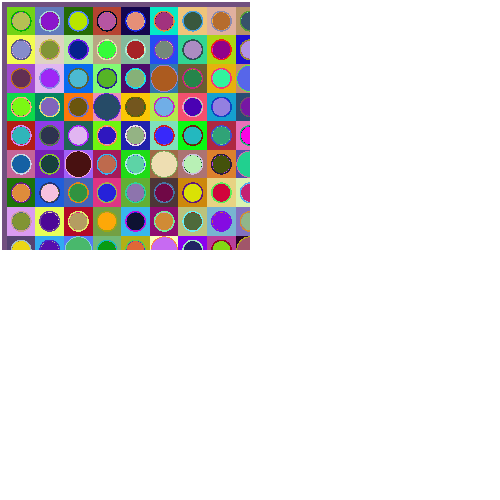

In [70]:
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (pitch_assembly+dr, pitch_assembly+dr)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [71]:


bounds = [-pitch_assembly/2, 0, -10, 0, +pitch_assembly/2, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)

# source = openmc.IndependentSource()
# source.space = openmc.stats.Point((0.1,0.1,0.))
# source.angle = openmc.stats.Isotropic()
# source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 80000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

### Define and choose energy group

In [72]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [73]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi']#, 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [74]:
model.export_to_xml()
sp_file = model.run()
sp = openmc.StatePoint(sp_file)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=36431.
  warn(msg, IDWarning)


[Machine2:17294] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

### Plot Flux

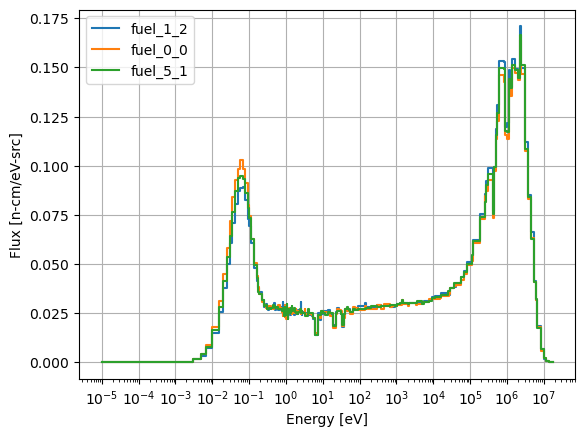

In [76]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

#Enter the name of the cell type string// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_plot=['fuel_1_2','fuel_0_0','fuel_5_1']#,'clad','moderator']


sp = openmc.StatePoint(sp_file)
sp.tallies
tally_flux_id=[]
for index, tally in enumerate(sp.tallies):
    # print(index)
    # print(tally)
    if index==0:
        index_tally=tally
    # if sp.tallies[tally].scores==['flux']:
    #     t=sp.tallies[tally]
t=sp.tallies[index_tally]
def flux_cell(cell):
    
    cell_index = 99
    cell_id=99
    # print(model.geometry.get_all_material_cells().values())
    i=0
    for all_cell in model.geometry.get_all_material_cells().values():
        i=i+1
        if all_cell.name==cell:
            cell_index=all_cell.id
            cell_id=i-1
            # print(cell_id)
            
    tally_data_reshaped =t.get_reshaped_data()
    flux=tally_data_reshaped[cell_id]
    
    liste_reduced = []
    for under_liste in flux:
        nombre = under_liste[0][0]
        liste_reduced.append(nombre)
    flux=liste_reduced
    return(flux)
    

dE=np.diff(choose_group)
Emid=choose_group[:-1]+dE/2

fig, ax = plt.subplots()
for i,cell in enumerate(cell_plot):
    flux=flux_cell(cell_plot[i])    
    mg_spectrum=flux / np.sum(flux)
    ax.step(choose_group[:-1], Emid*mg_spectrum/dE, where='post', label=cell_plot[i])
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
plt.show()


### Print MGXS

In [75]:
mgxs_lib.load_from_statepoint(sp)
type(mgxs_lib)
reaction_print = 'total'
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_print=fuel_2_5
df_mgxs = mgxs_lib.get_mgxs(cell_print, reaction_print)
df_mgxs.print_xs()

KeyboardInterrupt: 

### Plot MGXS from mgxs directory

In [ ]:
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///

reaction_plot = 'fission'
cell_plot_1 = fuel_O_O
cell_name_1='fuel_O_O'
cell_plot_2 = fuel_7_7
cell_name_2='fuel_7_7'


mgxs_plot_1 = mgxs_lib.get_mgxs(cell_plot_1, reaction_plot)

mgxs1=mgxs_plot_1.get_pandas_dataframe(xs_type='macro')['mean'].values
mgxs_plot_2 = mgxs_lib.get_mgxs(cell_plot_2, reaction_plot)
mgxs2=mgxs_plot_2.get_pandas_dataframe(xs_type='macro')['mean'].values


fig, ax = plt.subplots()
ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1) 
ax.step(choose_group[:-1], np.flip(mgxs2), where='post', label=cell_name_2) 

        
ax.set_xscale('log')

ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()